In [1]:
from imports import *

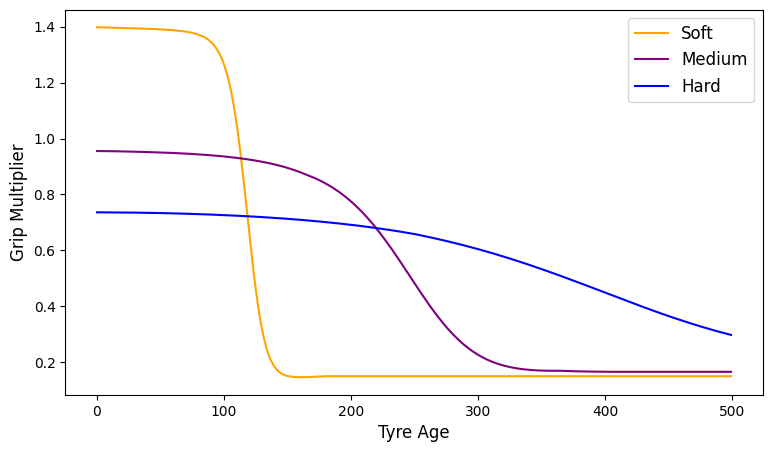

In [2]:
plot_tyre_degradation()

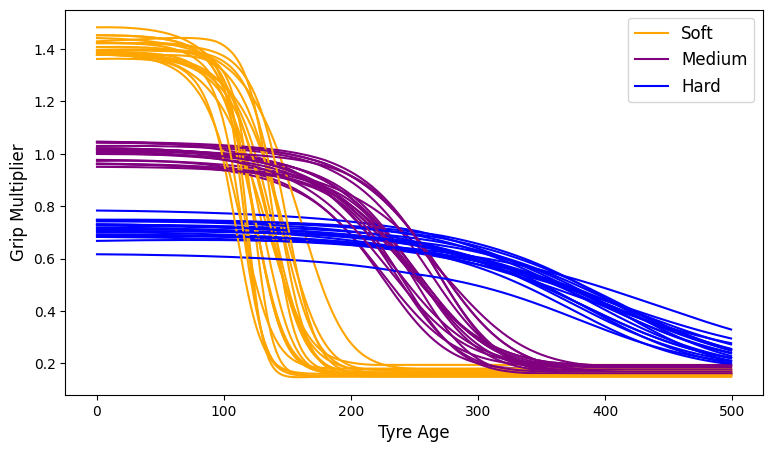

In [3]:
plot_tyre_degradation(20)

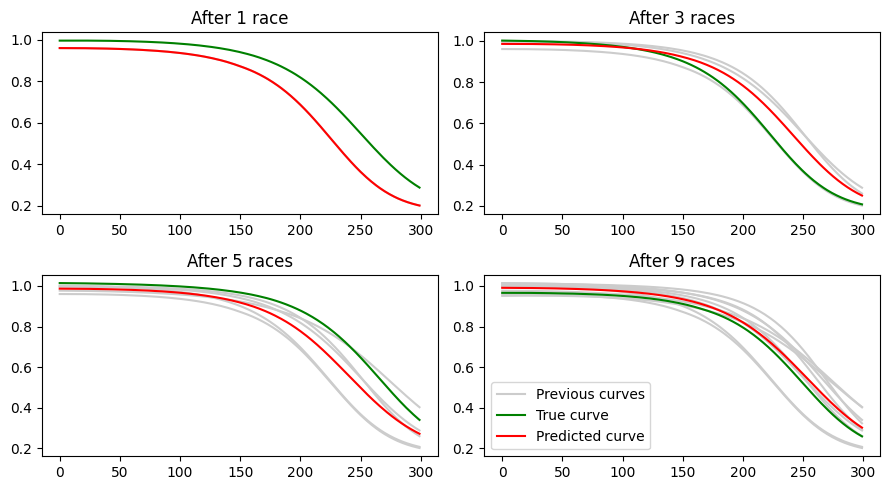

In [4]:
num_races = 10
x = np.arange(300)
grips = np.zeros((x.size, num_races))

# Sample a tyre curve for each race
set_seed(1)
for i in range(num_races):
    tyre_model = TyreModel()
    tyre_model.new_tyres_please(TyreChoice.Medium)
    grips[:, i] = tyre_model.get_grip(x)

# Use the mean
fig = plt.figure(figsize=(9, 5))
for i, n in enumerate([1, 3, 5, 9]):
    ax = fig.add_subplot(2, 2, i + 1)
    past_line = ax.plot(x, grips[:, :n], c=(0.8, 0.8, 0.8))[0]
    true_line = ax.plot(x, grips[:, n], c='g')[0]
    prediction_line = ax.plot(x, np.mean(grips[:, :n], axis=1), c='r')[0]
    ax.set_title(f'After {n} race{"s" if n > 1 else ""}')
ax.legend([past_line, true_line, prediction_line], ['Previous curves', 'True curve', 'Predicted curve'])
fig.tight_layout()

### The STUFF

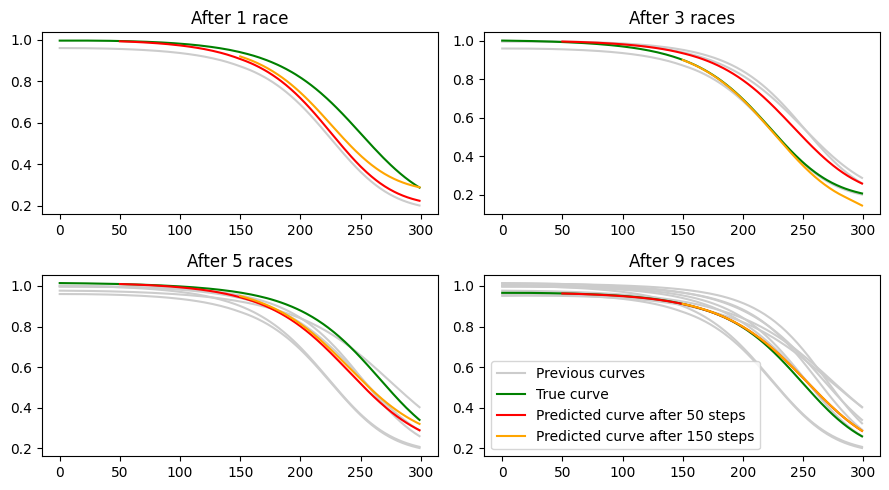

In [5]:
# This cell requires the ones before it to run
from scipy.optimize import minimize
from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9, 5))
T = [50, 150]                 # make a prediction after this number of turns 
colours = ['r', 'orange']
def predict_tyre_grip(age, age_offset, grip_offset, grip_scale):
   return grip_scale * interp(age + age_offset) + grip_offset
def obj_fun(param):           # squared error between prediction and observed data up to time t
    return np.mean((grips[:t, n] - predict_tyre_grip(x[:t], *param))**2)
    
for i, n in enumerate([1, 3, 5, 9]):
    ax = fig.add_subplot(2, 2, i + 1)
    past_line = ax.plot(x, grips[:, :n], c=(0.8, 0.8, 0.8))[0]
    true_line = ax.plot(x, grips[:, n], c='g')[0]
    
    m = np.mean(grips[:, :n], axis=1)      # average curve from previous races
    interp = interp1d(x, m, kind='linear', fill_value='extrapolate')
    prediction_lines = []
    for ti, t in enumerate(T):
        p0 = [0, 0, 1]
        res = minimize(obj_fun, p0, bounds=[(-50, 50), (-0.1, 0.1), (0.9, 1.1)])
        prediction_lines += ax.plot(x[t:], predict_tyre_grip(x[t:], *res.x), c=colours[ti])
    ax.set_title(f'After {n} race{"s" if n > 1 else ""}')
    
ax.legend([past_line, true_line] + prediction_lines, 
          ['Previous curves', 'True curve'] + [f'Predicted curve after {t} steps' for t in T])

fig.tight_layout()

In [6]:
from drivers.prodriver import ProDriver

driver_name = 'SuchAPro'
driver = ProDriver(driver_name, allow_pitstops=False, weather_on=False)
driver.grip_fig = plt.figure(figsize=(9, 5))  # assigning a grip_fig will trigger the extra plot. Needs to be in cell before

<Figure size 900x500 with 0 Axes>

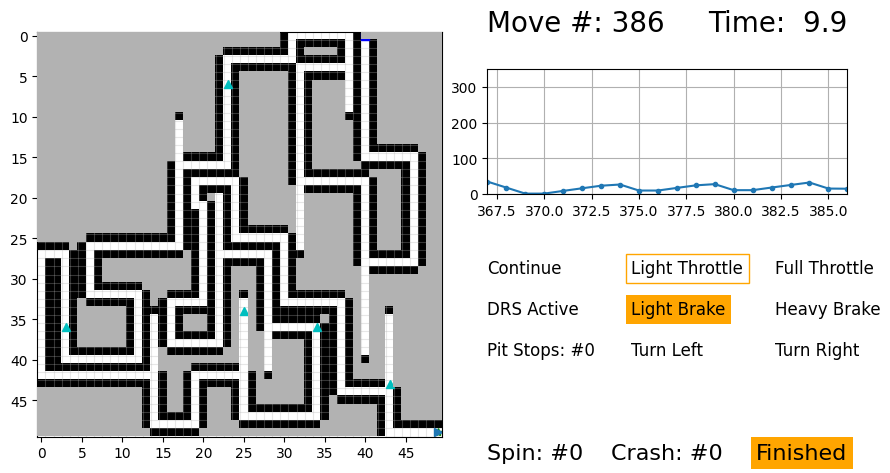

Opening DRS
Opening DRS


In [7]:
season = Season(level=Level.Pro)
print('Running initial races...')
season.race(driver=driver, track_indices=range(6), use_weather=False) # Run a few races first to get our driver's eye in 
print('done.')
set_seed(0)
season.race(driver=driver, track_indices=[5], plot=True, use_safety_car=False, use_weather=False)  # focus on tyres for now
plt.close()

In [8]:
driver.allow_pitstops = True

driver.grip_fig = plt.figure(figsize=(9, 5))  # recreate so it plots below and not in cell above

<Figure size 900x500 with 0 Axes>

In [9]:
# Don't forget to run the cell above to create the figures each time before running this cell
set_seed(0)
season.race(driver=driver, track_indices=[5], plot=True, use_safety_car=False, use_weather=False)
plt.close()

<Figure size 900x500 with 0 Axes>

Opening DRS
Opening DRS
Box! Box! Box!


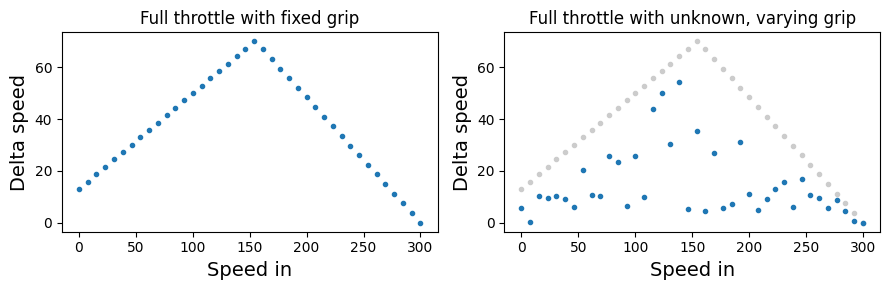

In [10]:
car = Car.get_car_for_level(Level.Pro)
set_seed(2)
speed_in = np.linspace(0, 300, 40)
speed_out = np.zeros_like(speed_in)
speed_out_unknown_grip = np.zeros_like(speed_in)
for i, s in enumerate(speed_in):
    speed_out[i] = car.dynamics_model.full_throttle(speed_in[i], grip_multiplier=1)
    speed_out_unknown_grip[i] = car.dynamics_model.full_throttle(speed_in[i], grip_multiplier=rng().rand())

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(speed_in, speed_out - speed_in, '.')
ax.set_xlabel('Speed in', fontsize=14)
ax.set_ylabel('Delta speed', fontsize=14)
ax.set_title('Full throttle with fixed grip')

ax = fig.add_subplot(1, 2, 2)
ax.plot(speed_in, speed_out - speed_in, '.', c=(0.8, 0.8, 0.8))
ax.plot(speed_in, speed_out_unknown_grip - speed_in, '.')
ax.set_xlabel('Speed in', fontsize=14)
ax.set_ylabel('Delta speed', fontsize=14)
ax.set_title('Full throttle with unknown, varying grip')
fig.tight_layout()



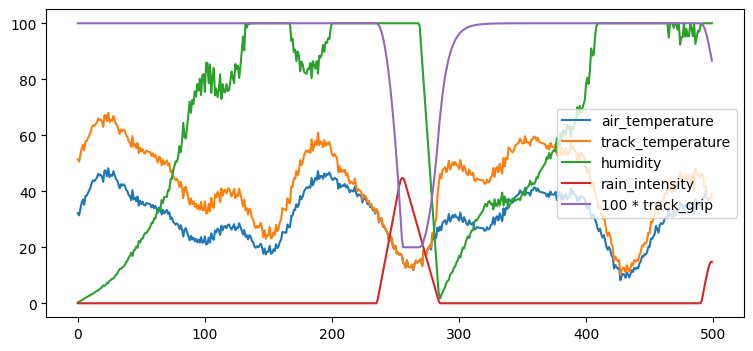

In [11]:
weather_station = WeatherStation()
plt.figure(figsize=(9, 4))
T = 500          # number of time points to plot
for name, data in weather_station.weather_data.items():
    plt.plot(data[:T], label=name)
plt.plot(100*weather_station.track_grip[:T], label='100 * track_grip')
plt.legend()

RMSE is 0.08, max error is 0.37


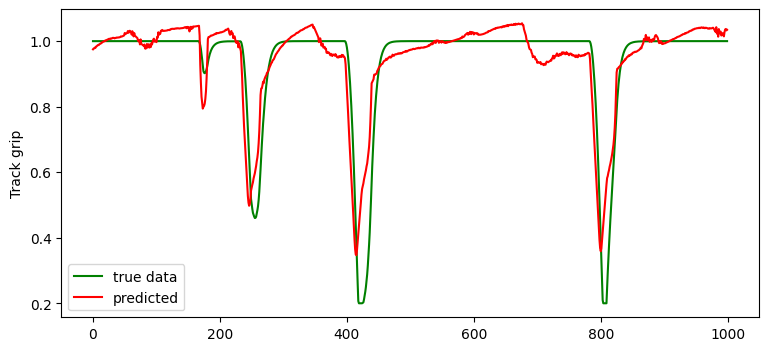

In [12]:
# **** This cell requires the previous cells in the weather forecasting section to run

from sklearn.linear_model import LinearRegression

# Stack each of the variables in the weather state (air temp, etc) into columns of an array
# Row t of X has the weather state data for time point t and y the track grip value for the same time point
X = np.hstack([data[:, None] for data in weather_station.weather_data.values()])
y = weather_station.track_grip[:, None]

# Fit the linear model from weather state to track grip
model = LinearRegression()
model.fit(X[:4000, :], y[:4000, :])                    # train on first 4000 points

# Make predictions and compute error
ys = model.predict(X[4000:, :])                        # test on remaining 1000 points
sq_err = (ys - y[4000:, :])**2
print(f'RMSE is {np.sqrt(np.mean(sq_err)):.2f}, max error is {np.sqrt(np.max(sq_err)):.2f}')

plt.figure(figsize=(9, 4))
plt.plot(y[4000:], 'g', label='true data')
plt.plot(ys, 'r', label='predicted')
plt.legend()
plt.ylabel('Track grip');

RMSE is 0.002, max error is 0.04


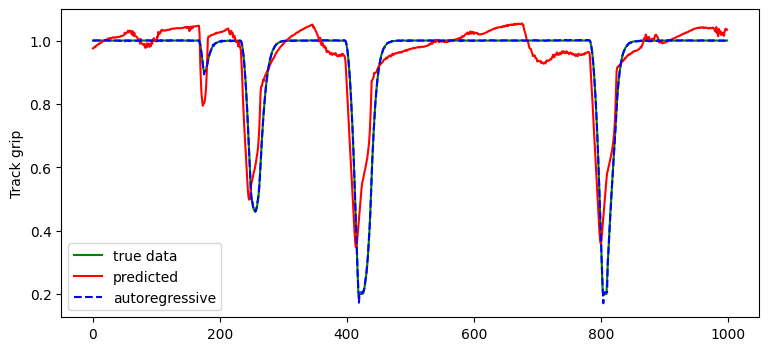

In [13]:
# **** This cell requires the previous cells in the weather forecasting section to run
num_previous_steps = 50

# Format the weather state (x) and track grip (y) data into arrays with format:
#     row t of inputs_y  = [ x_t, y_t-1, x_t-1, ..., y_t-num_previous_steps, x_t-num_previous_steps ]
#     row t of targets_y = [ y_t ]
inputs_y, targets_y = ProDriver.format_ar_arrays_for_y(X, y, num_previous_steps=num_previous_steps)

# Fit a linear model from inputs_y (previous x and y data) -> targets_y (current y)
model_y = LinearRegression().fit(inputs_y[:4000-num_previous_steps, :], targets_y[:4000-num_previous_steps, :])

# Make predictions. 
# Autoregressive arrays have the first num_previous_steps data points cut off so targets_y[0] = y[num_previous_steps]
ys_ar = model_y.predict(inputs_y[4000-num_previous_steps:, :])
sq_err = (ys_ar - y[4000:, :])**2
print(f'RMSE is {np.sqrt(np.mean(sq_err)):.3f}, max error is {np.sqrt(np.max(sq_err)):.2f}')

plt.figure(figsize=(9, 4))
plt.plot(y[4000:], 'g', label='true data')
plt.plot(ys, 'r', label='predicted')
plt.plot(ys_ar, 'b--', label='autoregressive');
plt.legend()
plt.ylabel('Track grip');

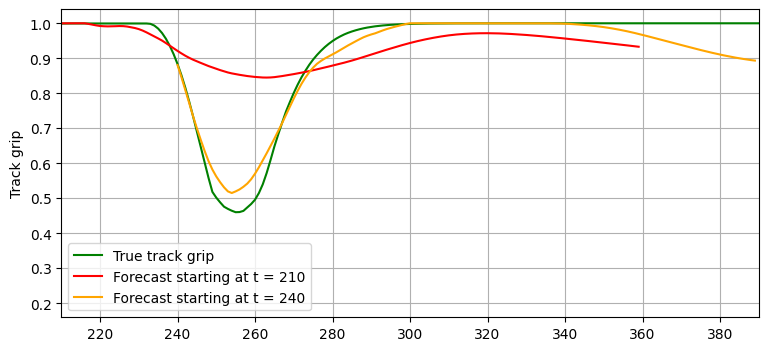

In [14]:
# **** This cell requires the previous cells in the weather forecasting section to run
# Fit a model to predict the weather state (x) at time t+1 given weather state and track grip up to time t
inputs_x, targets_x = ProDriver.format_ar_arrays_for_x(X, y, num_previous_steps=num_previous_steps)
model_x = LinearRegression().fit(inputs_x[:4000-num_previous_steps, :], targets_x[:4000-num_previous_steps, :])

# Forecast track grip by alternating predicitons of y_t and x_t+1
H = 150                   # number of steps to predict into the future
t0_1 = 210                # starting point for forecast
ys_1 = ProDriver.autoregressive_forecast(model_y=model_y, model_x=model_x, historic_x=X[:4000+t0_1, :], 
                                         historic_y=y[:4000+t0_1], current_x=X[4000+t0_1, :], num_forecast_steps=H, 
                                         bound_y=True, bound_x=True)

t0_2 = 240                # starting point for forecast
ys_2 = ProDriver.autoregressive_forecast(model_y=model_y, model_x=model_x, historic_x=X[:4000+t0_2, :], 
                                         historic_y=y[:4000+t0_2], current_x=X[4000+t0_2, :], num_forecast_steps=H, 
                                         bound_y=True, bound_x=True)

fig = plt.figure(figsize=(9, 4))
plt.plot(y[4000:], 'g', label='True track grip')
plt.plot(np.arange(t0_1, t0_1+H), ys_1, 'r', label=f'Forecast starting at t = {t0_1}')
plt.plot(np.arange(t0_2, t0_2+H), ys_2, 'orange', label=f'Forecast starting at t = {t0_2}')
plt.xlim(min(t0_1, t0_2), max(t0_1, t0_2) + H)
plt.grid()
plt.ylabel('Track grip')
plt.legend();

In [15]:
# Using the same driver from above - make sure you have run those cells!
driver.weather_on = True

In [16]:
# Create figure placeholder
driver.grip_fig = plt.figure(figsize=(9, 5))       # assigning a grip_fig will trigger the extra plot

<Figure size 900x500 with 0 Axes>

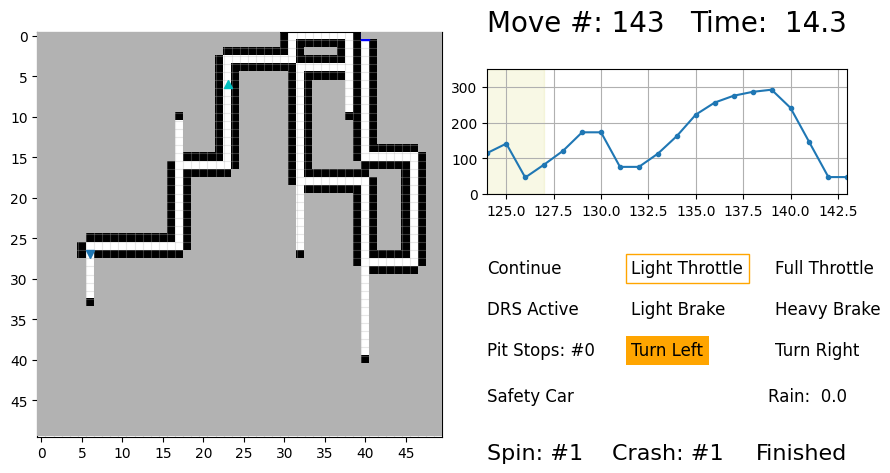

	Crashed! We targeted 37 speed and were going  36. EoS speed unmodified is  138. We used a grip of 0.28 which gives  39
Safety car deployed for 15 turns at 100 speed
Opening DRS
Safety car no longer active
Safety car deployed for 12 turns at 135 speed
	Increasing estimate of safety car speed to  143.1
	Car speed of  141.1 exceeds safety car, penalty is now 1
	Decreasing estimate of safety car speed to  104.9
	Increasing estimate of safety car speed to  142.1
Safety car no longer active


In [17]:
# Don't forget to re-run the cell above each time if you run this one more than once
print('Running initial races...')
season.race(driver=driver, track_indices=range(2))              # Run a few races first to get our driver's eye in 
print('done.')
set_seed(0)
season.race(driver=driver, track_indices=[5], plot=True)        # turn everything on!
plt.close()